In [1]:
# ---------------------------------导入模块------------------------------
import jieba
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import re
import jieba.posseg as psg

D:\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
D:\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
D:\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
D:\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, 

In [3]:
fig_path = 'E:/泰迪杯/数据挖掘2021/论文图片/'
fig_path_lda = fig_path + 'LDA/'
fig_path_lda_best_topic = fig_path_lda + '景区.html'
fig_path_lda_topics = fig_path_lda + '景区.png'
text_path = 'E:/泰迪杯/数据挖掘2021/文本预处理结果/景区utf-8.csv'
result_path = 'E:/泰迪杯/数据挖掘2021/LDA结果/景区.csv'
result_path_gbk = 'E:/泰迪杯/数据挖掘2021/LDA结果/景区gbk.csv'

In [4]:
# ----------------------------------获取数据------------------------------------
path0 = 'E:/泰迪杯/数据挖掘2021/C/C题数据/清洗过的数据/景区评论utf-8.csv'
reviews = pd.read_csv(path0, encoding='utf-8')['评论内容']
result = pd.read_csv(text_path, encoding='utf-8')

In [5]:
reviews.shape

(58668,)

In [6]:
result.shape

(589531, 4)

In [7]:
result

,index_content,word,nature,index_word
0,1,亲子,n,0
1,1,绝佳,z,1
2,1,场所,n,2
3,1,贵,a,3
4,1,接受,v,4
...,...,...,...,...
589526,58668,旅行社,n,0
589527,58668,不负责任,l,1
589528,58668,售票,n,2
589529,58668,协调,v,3


In [8]:
reviews

0        是亲子游的绝佳场所，门票就是有点贵，不过可以接受，爷爷奶奶不放心小朋友也跟上来了，当天我们十...
1        **景区差不多，票价偏贵了。大马戏比较精彩，八点的场次，6点40才能检票进入，我们6点多看看...
2        很有**特色的亲子酒店，房间里的装修很可爱，小孩子特别喜欢，洗漱用品也很有特色，对应的房间还...
3        有园区的工作人员在那，他会主动给你园区里的地图和表演的时间安排，很周到，上接驳车大概也是34...
4        周五逃课跟朋友在广州集合！终于如愿以偿的到达欢乐世界。学生票198 需要出示相关证件（校卡或...
                               ...                        
58663    还好吧。我们刚刚到瀑布楼遇到一点小意外，打电话到景区办公室要求帮助，景区值班领导马上行动，在...
58664                                 山高路远，走的很辛苦。景色宜人爬山很累。
58665                             环境很好，空气非常棒，很适合全家旅游，特别是避暑
58666                                  都很方便，价格实惠吧，可以预早就订好。
58667                          旅行社不负责任 到了景点没有与门票售票协调好 等了很久
Name: 评论内容, Length: 58668, dtype: object

In [9]:
reviews.shape

(58668,)

# LDA主题分析

## 将分词的结果合并为嵌套列表，每一个小列表是同一评论的分词结果

In [10]:
# 传入分词后的数据框的每一行
def fenci(x, result_fenci):
    length = len(result_fenci)  # length对应index_content,值对应每条评论分词结果组成的列表
    if length < x[0]:
        for i in range(length + 1, x[0] + 1):
            length += 1
            result_fenci[length]=[]
    result_fenci[length].append(x[1])
    return result_fenci

In [11]:
# result_fenci第0个位置对应index_content=1
result_fenci = {}
result.apply(lambda x: fenci(x, result_fenci), axis=1)
result_fenci = list(result_fenci.values())

In [12]:
print('result_fenci length = ', len(result_fenci))
result_fenci

result_fenci length =  58668


[['亲子',
  '绝佳',
  '场所',
  '贵',
  '接受',
  '爷爷奶奶',
  '放心',
  '跟上来',
  '当天',
  '十点',
  '错过',
  '节假日',
  '错峰',
  '出行',
  '动物园',
  '逛完',
  '两种',
  '路线',
  '逛',
  '早上',
  '先',
  '坐',
  '缆车',
  '缆车',
  '排',
  '半小时',
  '队',
  '火车',
  '步行',
  '区',
  '转完',
  '了去',
  '坐',
  '下午',
  '四点',
  '火车',
  '站',
  '下雨',
  '地铁站',
  '男',
  '北门',
  '接驳',
  '车',
  '算',
  '满意',
  '动物',
  '表演',
  '大象',
  '表演'],
 ['票价',
  '偏贵',
  '马戏',
  '精彩',
  '八点',
  '场次',
  '检票',
  '位置',
  '早早',
  '拿票',
  '动物园',
  '北门',
  '猫和老鼠',
  '旗帜',
  '工作人员',
  '找到',
  '就行了'],
 ['特色',
  '亲子',
  '房间',
  '装修',
  '可爱',
  '特别',
  '喜欢',
  '洗漱',
  '用品',
  '特色',
  '房间',
  '送',
  '动物',
  '绘本',
  '带走',
  '房间',
  '大小',
  '很大',
  '动物园',
  '北门',
  '步行',
  '分钟',
  '门卡',
  '门',
  '卡里',
  '一张',
  '纸条',
  '进园',
  '坐',
  '缆车',
  '电影',
  '走',
  '快递',
  '通道',
  '一点',
  '性价比',
  '很高',
  '大点',
  '再来',
  '楼下',
  '茶餐厅',
  '马路',
  '对面',
  '餐厅',
  '吃',
  '海鲜',
  '早茶',
  '楼下',
  '好吃'],
 ['园区',
  '工作人员',
  '主动',
  '园区',
  '地图',
  '表演',
  '安排',
  '周到',
  '接驳',
  '车

## 创建字典和词袋

In [13]:
id2word = corpora.Dictionary(result_fenci)

# 将字典转换为词袋,为文档中的每一个单词创建唯一的ID
corpus = [id2word.doc2bow(sentence) for sentence in result_fenci]
print(corpus[:1])
# [[(1,3),(2,1)],[]] 返回的结果是列表套子列表，子列表中套元组，如（1,3）代表1在第一个文档中出现3次。

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1)]]


In [14]:
# 可通过如下预期查询id对应的词
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('下午', 1), ('下雨', 1), ('两种', 1), ('了去', 1), ('亲子', 1), ('先', 1), ('出行', 1), ('动物', 1), ('动物园', 1), ('北门', 1), ('区', 1), ('十点', 1), ('半小时', 1), ('四点', 1), ('地铁站', 1), ('场所', 1), ('坐', 2), ('大象', 1), ('当天', 1), ('排', 1), ('接受', 1), ('接驳', 1), ('放心', 1), ('早上', 1), ('步行', 1), ('满意', 1), ('火车', 2), ('爷爷奶奶', 1), ('男', 1), ('站', 1), ('算', 1), ('绝佳', 1), ('缆车', 2), ('节假日', 1), ('表演', 2), ('贵', 1), ('跟上来', 1), ('路线', 1), ('车', 1), ('转完', 1), ('逛', 1), ('逛完', 1), ('错峰', 1), ('错过', 1), ('队', 1)]]


# 构建LDA主题模型

## 寻找LDA的最佳主题数

In [20]:
coherence_values = []
model_list = []
for num_topics in range(5,22,2):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    # random_state=100,
                    # update_every=1,
                    # chunksize=100,
                    # passes=10,
                    # alpha='auto',
                    # per_word_topics=True
)
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=result_fenci, dictionary=id2word, coherence='c_v')
    coherence_values.append(round(coherencemodel.get_coherence(),3))

## 最佳主题数可视化展示

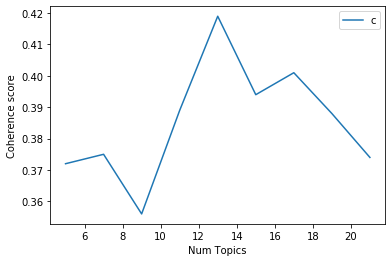

In [21]:
# 利用可视化的方式进行展示
x = range(5,22,2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig(fig_path_lda_topics)
plt.show()

## 展示不同主题数的一致性分数

In [22]:
# 展示不同的主题数对应的一致性分数
i = 0
best_model_pos = 0  # 最好的主题数在列表中的位置
best_num_topics = 5 # 最好的主题数量
best_cv = coherence_values[0]  # 最好的一致性分数
print(best_cv)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if cv > best_cv:
        best_model_pos = i
        best_num_topics = m
        best_cv = cv
    i = i + 1
print("Best Num Topics =", best_num_topics, " has Coherence Value of", round(best_cv, 4))

0.372
Num Topics = 5  has Coherence Value of 0.372
Num Topics = 7  has Coherence Value of 0.375
Num Topics = 9  has Coherence Value of 0.356
Num Topics = 11  has Coherence Value of 0.389
Num Topics = 13  has Coherence Value of 0.419
Num Topics = 15  has Coherence Value of 0.394
Num Topics = 17  has Coherence Value of 0.401
Num Topics = 19  has Coherence Value of 0.388
Num Topics = 21  has Coherence Value of 0.374
Best Num Topics = 13  has Coherence Value of 0.419


## LDA模型中的最佳主题

In [23]:
# 根据一致性得分，选择具有最高CV的模型，选择的主题数是
# 选择模型并打印主题
optimal_model = model_list[best_model_pos]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.053*"值得" + 0.048*"适合" + 0.030*"环境" + 0.025*"干净" + 0.021*"休闲" + 0.020*"公园" '
  '+ 0.020*"空气清新" + 0.018*"瀑布" + 0.018*"水" + 0.017*"很漂亮" + 0.015*"好去处" + '
  '0.015*"度假" + 0.014*"特色" + 0.012*"很大" + 0.012*"环境优美"'),
 (1,
  '0.126*"风景" + 0.033*"表演" + 0.028*"值得" + 0.024*"一般般" + 0.024*"位于" + '
  '0.022*"晚上" + 0.021*"好看" + 0.020*"建筑" + 0.019*"美丽" + 0.018*"大自然" + 0.017*"旧" '
  '+ 0.015*"值得一看" + 0.013*"节目" + 0.012*"风格" + 0.011*"特色"'),
 (2,
  '0.127*"好玩" + 0.055*"开心" + 0.049*"太" + 0.030*"天气" + 0.024*"项目" + 0.023*"特别" '
  '+ 0.022*"舒服" + 0.022*"夏天" + 0.021*"热" + 0.020*"风景" + 0.018*"乐园" + '
  '0.018*"水上" + 0.017*"刺激" + 0.013*"避暑" + 0.012*"下次"'),
 (3,
  '0.027*"走" + 0.027*"高" + 0.015*"性价比" + 0.014*"免费" + 0.014*"太" + 0.013*"坐" + '
  '0.012*"建议" + 0.012*"观音" + 0.011*"开车" + 0.011*"感觉" + 0.010*"路" + 0.010*"好好" '
  '+ 0.009*"收费" + 0.009*"游客" + 0.008*"栈道"'),
 (4,
  '0.120*"便宜" + 0.049*"价格" + 0.046*"优惠" + 0.045*"网上" + 0.031*"现场" + 0.027*"不用" '
  '+ 0.026*"实惠" + 0.023*"排队" + 0.022*"购票" + 0.016*"订" + 

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.225984  0.140156       1        1  13.156306
6     -0.273259  0.025467       2        1  13.144596
0      0.120103  0.176367       3        1  10.404309
12     0.083628  0.081160       4        1   8.213509
2      0.087275 -0.021927       5        1   7.953703
7     -0.001379  0.124961       6        1   7.770697
1      0.161809 -0.001202       7        1   7.278380
10     0.169989 -0.016377       8        1   6.024198
11     0.005054  0.096575       9        1   5.957321
5     -0.038853 -0.175557      10        1   5.767699
4     -0.066690 -0.275526      11        1   5.645883
9     -0.097877 -0.010242      12        1   5.326613
8      0.076183 -0.143855      13        1   3.356786, topic_info=     Term         Freq        Total Category  logprob  loglift
311    好玩  5990.000000  5990.000000  Default  30.0000  30.0000
2494   景色  4947.000000  4947.000000  Default  29.0000  29.0000
5126   风景  7148.000000  7148.000000  Default  28.0000  28.0000
8372   温泉  4212.000000  4212.000000  Default  27.0000  27.0000
398    便宜  4003.000000  4003.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1714    雨   201.785823   282.583258  Topic13  -4.5857   3.0574
4913    正   107.353947   147.366646  Topic13  -5.2168   3.0774
2177   遗憾   145.635694   388.984983  Topic13  -4.9118   2.4118
613    介绍   133.823334   313.475180  Topic13  -4.9964   2.5430
1117    开   140.979963   997.385596  Topic13  -4.9443   1.4377

[757 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2719      5  0.985504  ....
2334      5  0.980324   一下子
1711      1  0.155454   一个多
1711      9  0.840601   一个多
3834     13  0.979427   一会儿
...     ...       ...   ...
5245      4  0.994504     鱼
3316      6  0.990478     鸡
1242      2  0.377393    麻烦
1242     10  0.618092    麻烦
1242     12  0.002972    麻烦

[2191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 1, 13, 3, 8, 2, 11, 12, 6, 5, 10, 9])

In [25]:
# 将结果保存为该html文件
pyLDAvis.save_html(vis1, fig_path_lda_best_topic)

## 寻找具体的最佳话题

In [26]:
# ----------------------------------------在每个句子中找到主要话题--------------------------------------------
# 每个文档都包含多个主题。但是，通常只有一个主题是主导的。下面的代码为每个句子提取该主要主题，并在格式正确的输出中显示该主题和关键字的权重。
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),                 round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    # print(contents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # print(sent_topics_df)
    return(sent_topics_df)

In [27]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=result_fenci)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel(path+'resultsdatas.xlsx',index=False)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.6205,"上山, 广东, 导游, 山顶, 时, 走, 到达, 两个, 下午, 坐","[亲子, 绝佳, 场所, 贵, 接受, 爷爷奶奶, 放心, 跟上来, 当天, 十点, 错过,..."
1,1,6.0,0.3785,"上山, 广东, 导游, 山顶, 时, 走, 到达, 两个, 下午, 坐","[票价, 偏贵, 马戏, 精彩, 八点, 场次, 检票, 位置, 早早, 拿票, 动物园, ..."
2,2,7.0,0.4892,"环境, 贵, 很好, 没什么, 吃, 东西, 太, 差, 感觉, 风景","[特色, 亲子, 房间, 装修, 可爱, 特别, 喜欢, 洗漱, 用品, 特色, 房间, 送..."
3,3,6.0,0.6576,"上山, 广东, 导游, 山顶, 时, 走, 到达, 两个, 下午, 坐","[园区, 工作人员, 主动, 园区, 地图, 表演, 安排, 周到, 接驳, 车, 分钟, ..."
4,4,6.0,0.3430,"上山, 广东, 导游, 山顶, 时, 走, 到达, 两个, 下午, 坐","[周五, 逃课, 朋友, 广州, 集合, 终于, 如愿以偿, 到达, 欢乐, 世界, 学生票..."
5,5,4.0,0.3939,"便宜, 价格, 优惠, 网上, 现场, 不用, 实惠, 排队, 购票, 订","[优惠, 力度, 成人, 价是值, 回来]"
6,6,12.0,0.4101,"动物, 爬, 岛, 沙滩, 天然, 氧吧, 表演, 广州, 动物园, 种类","[提前, 这位, 代理商, 订, 官方, 不到, 马戏, 精彩, 广州, 终身, 忘不掉]"
7,7,12.0,0.2623,"动物, 爬, 岛, 沙滩, 天然, 氧吧, 表演, 广州, 动物园, 种类","[收费, 高, 人员, 服务, 确实, 热情, 动物园, 太, 逛逛, 拍拍, 吃饭, 特别..."
8,8,3.0,0.2864,"走, 高, 性价比, 免费, 太, 坐, 建议, 观音, 开车, 感觉","[飞, 乐园, 去过, 动物园, 感觉, 一处, 讲解员, 讲解, 鸟类, 生活, 知识, ..."
9,9,3.0,0.7299,"走, 高, 性价比, 免费, 太, 坐, 建议, 观音, 开车, 感觉","[园区, 联票, 郁闷, 家, 一米, 碰见, 傻子, 验票, 员, 硬, 量, 身高, 行..."


In [28]:
df_dominant_topic.to_csv(result_path, encoding='utf-8', index=False)
df_dominant_topic.to_csv(result_path_gbk, encoding='gbk', index=False)